In [1]:
import matplotlib.pyplot as plt
import matplotlib

%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (9.0, 6.0)

In [2]:
import numpy as np

def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

In [24]:
import redis

r = redis.StrictRedis(host='172.17.0.1', port=6379, db=0)
r.keys()

[b'OUT_ThermalNetwork_t_sup_heat',
 b'IN_HeatPumpHeating_t_in_cold',
 b'OUT_HeatPumpHeating_t_out_cold_time',
 b'OUT_HeatPumpHeating_p_elec',
 b'OUT_HeatPumpCentral_p_heat_in_time',
 b'OUT_HeatPumpCentral_p_heat_out',
 b'IN_HeatPumpCooling_t_cool',
 b'OUT_ConsumerCooling_t_cooling',
 b'OUT_HeatPumpCentral_t_out_cold_time',
 b'OUT_ThermalNetwork_t_ret',
 b'OUT_ConsumerCooling_p_cooling_time',
 b'IN_ThermalNetwork_t_ret_cool',
 b'OUT_HeatPumpCooling_p_elec_time',
 b'OUT_HeatPumpCentral_p_elec',
 b'IN_ThermalNetwork_t_ret_heat',
 b'OUT_ConsumerHeating_p_heating',
 b'OUT_HeatPumpCooling_t_out_hot',
 b'IN_ThermalNetwork_t_ret_cool_time',
 b'OUT_ThermalNetwork_t_sup_heat_time',
 b'OUT_PowerNetwork_p_elec_tot_time',
 b'IN_HeatPumpHeating_t_heat',
 b'IN_HeatPumpHeating_t_heat_time',
 b'OUT_HeatPumpCentral_t_out_hot',
 b'OUT_HeatPumpHeating_t_out_hot_time',
 b'IN_HeatPumpHeating_p_heat',
 b'OUT_ConsumerCooling_t_cooling_time',
 b'OUT_ConsumerCooling_p_cooling',
 b'IN_HeatPumpCooling_t_cool_time

In [4]:
import pandas as pd

def get_data_from_pattern(pattern, pref='OUT'):
    list_of_keys = [key for key in r.keys(pref + '*' + pattern + '*') if 'time' not in str(key)]
    list_of_time = [key for key in r.keys(pref + '*' + pattern + '*time')]
    
    res = {}
    
    for (key_v, key_t) in zip(list_of_keys, list_of_time):
        value = list(map(float, r.lrange(key_v, 0, -1)))
        index = list(map(float, r.lrange(key_t, 0, -1)))

        index = pd.to_datetime(index, unit='s')

        res[key_v.decode("utf-8").replace(pref + '_', '')] = pd.Series(value, index=index)

    return res

In [27]:
results_th = get_data_from_pattern('*_t_in_*', pref='IN')

results_th.pop('HeatPumpCentral_t_in_hot')
results_th.keys()

dict_keys(['HeatPumpHeating_t_in_cold', 'HeatPumpCooling_t_in_hot'])

<IPython.core.display.Javascript object>


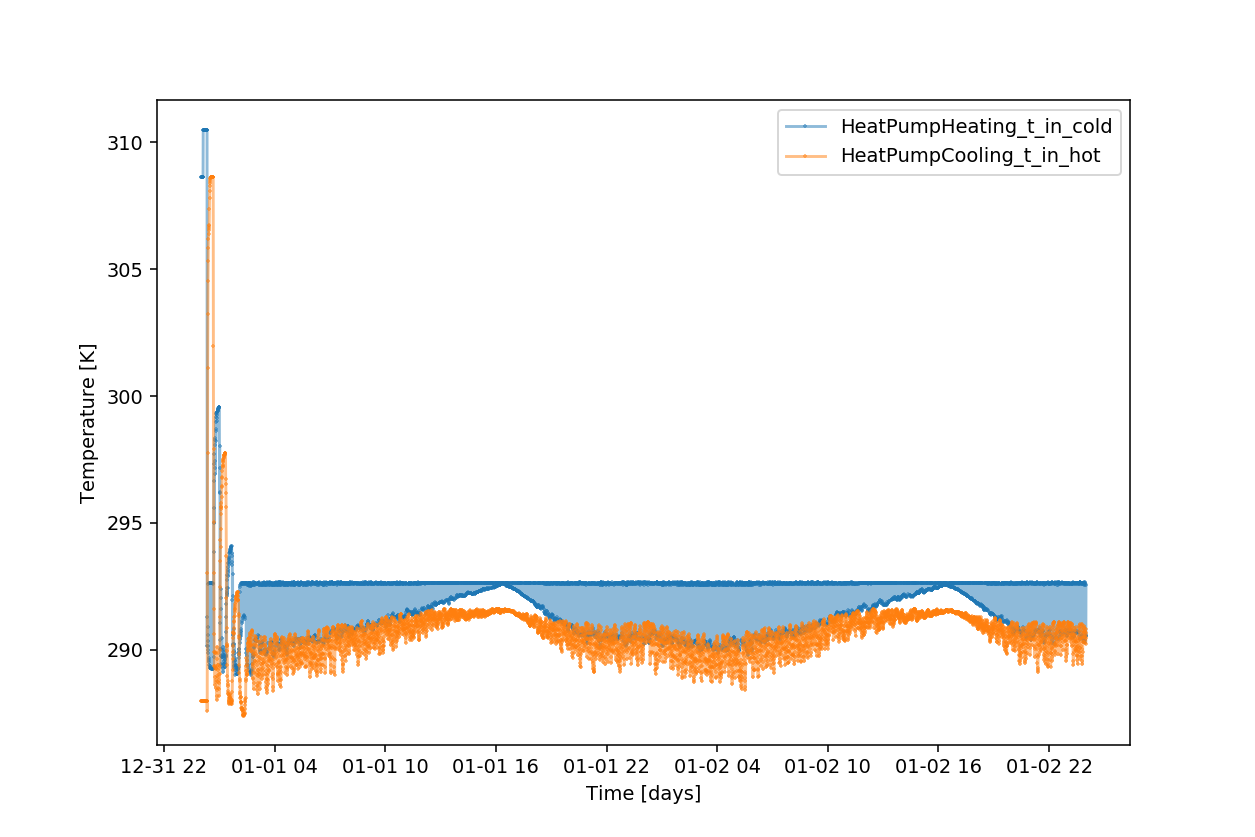

In [28]:
for key, value in results_th.items():
    rol = value.rolling(60, center=True).mean()
    
    freq = '3600S'
    sam = value.resample(freq).mean()
    
    plt.plot(value.index, value, '+-', alpha=0.5, label=key,  markersize=2.5)
    # plt.plot(rol.index, rol, alpha=0.5, label=key+'_rolling_average')
    # plt.plot(sam.index, sam, '--s', label=key+'_resample_'+freq, markersize=2.5)
    
    
    # rolling.plot(label=key+'_rolling_average', linestyle=None, marker='.', markersize=1)
    

plt.ylabel('Temperature [K]')
plt.xlabel('Time [days]')
plt.legend()
plt.show()